In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3, palette="Set2")

Титаник был крупнейшим пассажирским судном в 1912—1913 годах. Во время первого рейса затонул в северной Атлантике, столкнувшись с айсбергом в ночь с 14 на 15 апреля 1912 года, при этом погибло 1502 из 2224 пассажиров и членов экипажа. Данные о пассажирах были собраны в таблицы, которые можно скачать с <a href="https://www.kaggle.com/c/titanic/data" target="_blank">Kaggle</a>. Эти данные часто используются в качестве обучающих в анализе данных.

На дополнительном занятии 10 февраля будет показан простой пример работы с датасетом Титаник. Сейчас ваша задача &mdash; на основе простого анализа предоставленных данных обучить несколько классификаторов для определения выживших, иначе говоря, получить некоторые приближенные правила определения, выжил пассажир или нет, а также сравнить эти правила по качеству приближения.

#### 1. Подготовка данных

Загрузите данные с помощью `pandas`.

In [177]:
data = pd.read_csv("titanic.csv")

Разделите данные по строкам на две части случайным образом в соотношении 7:3. Первую часть мы будем называть *обучающей*, а вторую &mdash; *тестовой*.

In [178]:
train_data = data.sample(frac=0.7, random_state=42)
test_data = data.drop(train_data.index)

Из каждой части оставим несколько признаков, с которыми мы будем работать, а также отдельно &mdash; целевой признак. Примените к обеим частям таблицы функцию ниже

In [179]:
features_columns = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]
target_column = "Survived"


def get_features_and_target(data):
    features = data[features_columns]
    target = data[target_column]
    return features, target

In [180]:
train_features, train_target = get_features_and_target(train_data)

test_features, test_target = get_features_and_target(test_data)

#### 2. Исследование

**Внимание.** Эта часть задачи должна выполняться *исключительно на обучающих данных*. За использование тестовых данных решение не будет оценено.

Проведите визуальный анализ данных чтобы понять, как различные признаки влияют на целевой. Исследовать можно не целиком обучающие данные, а разделить их на две части по одному из признаков, а далее рассматривать каждую часть отдельно. 

*Не забывайте про информативность и эстетичность графиков.*

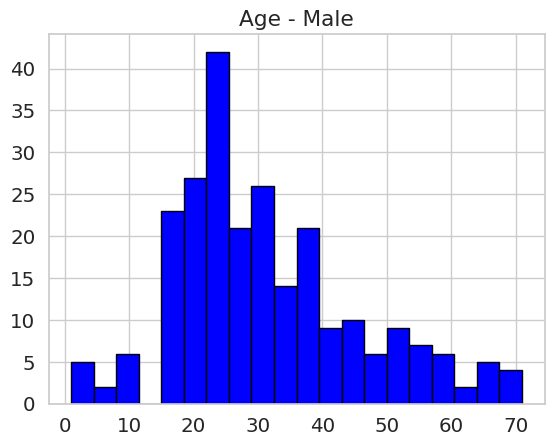

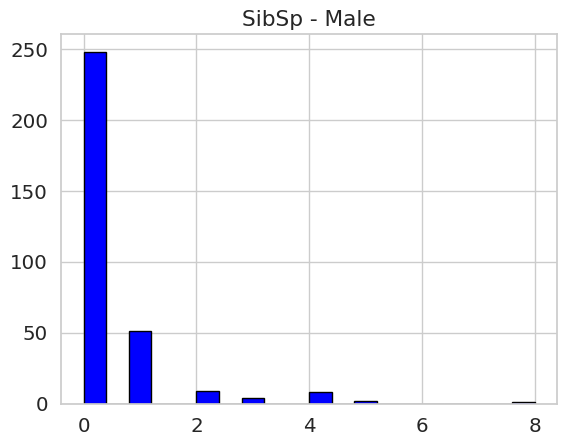

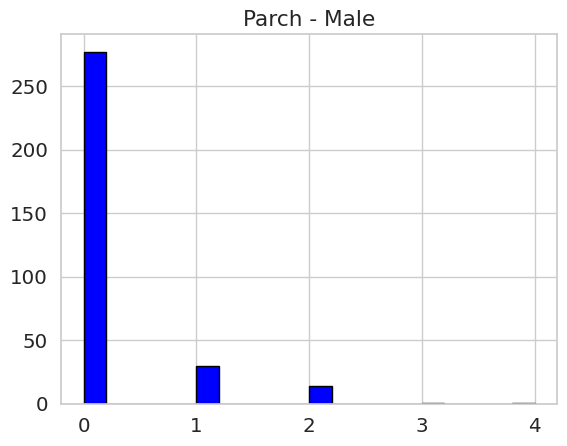

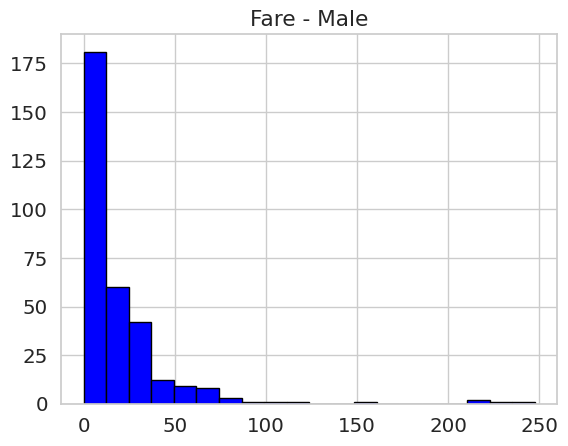

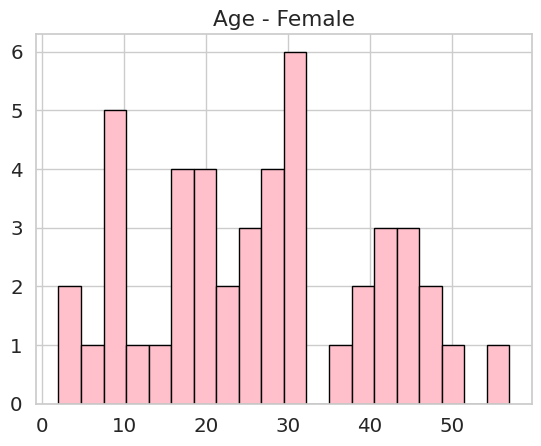

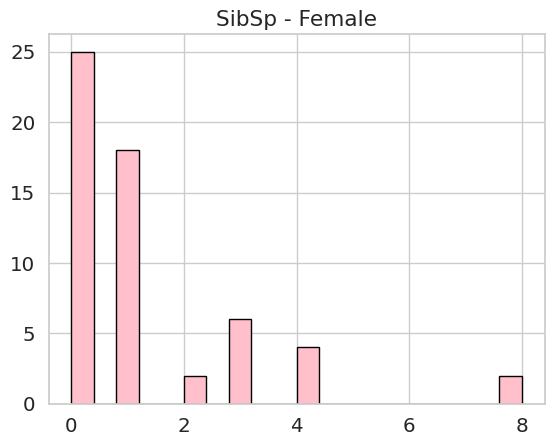

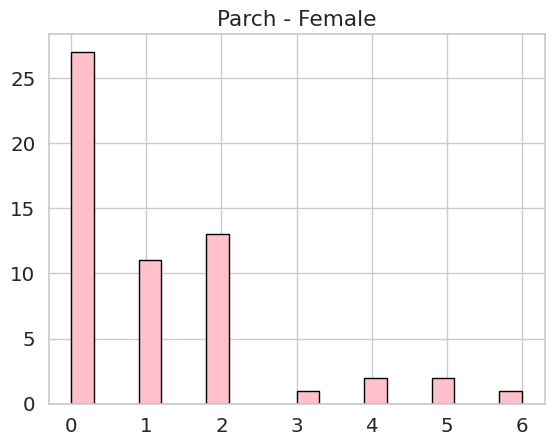

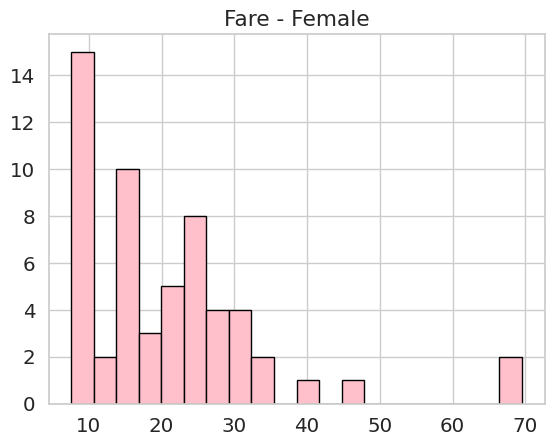

In [181]:
df_male = train_data[(train_data['Sex'] == 'male') & (train_data['Survived'] == 0)]
df_female = train_data[(train_data["Sex"] == "female") & (train_data['Survived'] == 0)]

df_num_male = df_male[["Age", "SibSp", "Parch", "Fare"]]
for i in df_num_male.columns:
    plt.hist(df_num_male[i], bins=20, edgecolor="black", color="blue")
    plt.title(f"{i} - Male")
    plt.show()

df_num_female = df_female[["Age", "SibSp", "Parch", "Fare"]]
for i in df_num_female.columns:
    plt.hist(df_num_female[i], bins=20, edgecolor="black", color="pink")
    plt.title(f"{i} - Female")
    plt.show()

#### 3. Классификация методом ближайшего соседа

Ранее в контесте вы уже реализовали функцию поиска ближайших соседей. Теперь давайте применим ее для решения нашей текущей задачи. 

Реализуйте функцию, которая для каждого объекта тестового набора данных найдет $k$ ближайших соседей из обучающего набора данных, и в качестве ответа возьмет наиболее часто встречающееся значение целевого признака среди найденных соседей. Обратите внимание, что соседей необходимо искать только среди объектов обучающего набора данных.

In [182]:
def find_nearest_points(A: np.ndarray, B: np.ndarray, k: int) -> np.ndarray:
    distances = np.sqrt(np.sum((B[:, np.newaxis, :] - A) ** 2, axis=2))
    nearest = np.argsort(distances, axis=1)[:, :k]
    return nearest + 1


def knn(features, train_features, train_target, k=1):
    predicted = []

    nearest_indices = find_nearest_points(train_features.values, features.values, k)

    for indices in nearest_indices:
        nearest_targets = train_target.iloc[indices - 1]
        predicted_value = nearest_targets.mode()[0]
        predicted.append(predicted_value)

    return pd.Series(predicted, index=features.index)

Постройте классификатор методом ближайшего соседа, используя только признаки `Age` и `Fare`. 

Какую метрику (функцию расстояния) вы при этом используете? Нужно ли предварительно что-то сделать с признаками?

In [183]:
#метрика
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

class KNNClassifier:
    def __init__(self, k, train_features, train_target):
        self.k = k
        self.train_features = train_features
        self.train_target = train_target

    def predict(self, X_test):
        return knn(X_test, self.train_features, self.train_target, self.k)



knn_classifier = KNNClassifier(k=5, train_features=train_features[['Age', 'Fare']], train_target=train_target)

pred = knn_classifier.predict(train_features[['Age', 'Fare']])

accuracy = np.mean(pred == train_target) 
print("Accuracy:", accuracy)


Accuracy: 0.6698717948717948


Возможно результаты могут стать лучше, при выборе другой метрики.

Как меняется результат классификации при другом количестве соседей? Рассмотрите хотя бы три различных нечетных значения количества соседей.

Accuracy for k = 5: 0.6699
Accuracy for k = 13: 0.6506
Accuracy for k = 77: 0.6827
Accuracy for k = 85: 0.6699
Accuracy for k = 115: 0.6619
Accuracy for k = 131: 0.6795
Accuracy for k = 215: 0.6699
Accuracy for k = 333: 0.6266
Accuracy for k = 555: 0.6090


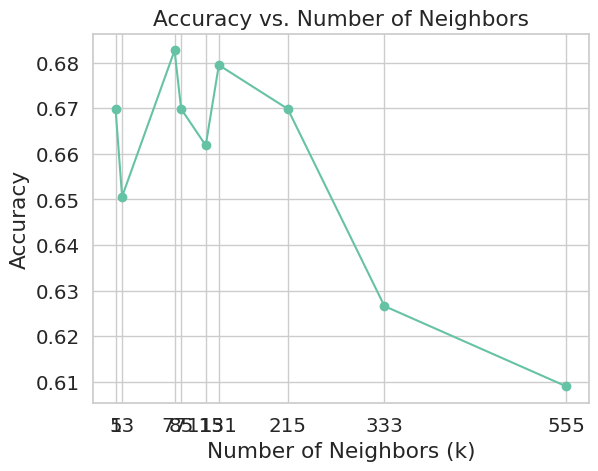

In [184]:
k_neighbours = [5, 13, 77, 85, 115, 131, 215, 333, 555]
accuracies = []

for i in k_neighbours:
    knn_classifier = KNNClassifier(k=i, train_features=train_features[['Age', 'Fare']], train_target=train_target)

    pred = knn_classifier.predict(train_features[['Age', 'Fare']])

    accuracy = np.mean(pred == train_target) 
    print(f"Accuracy for k = {i}: {accuracy:.4f}")
    accuracies.append(accuracy)

plt.plot(k_neighbours, accuracies, marker='o')
plt.title('Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_neighbours)
plt.grid(True)
plt.show()


С ростом количества соседей, точность уменьшается

Как можно было бы учесть другие признаки? Какие при этом могут возникнуть проблемы? 
Указать в train_features нужные нам признаки. Может возникнуть корреляция некоторых признаков.

Строить классификатор с другими признаками при этом не нужно.

#### 4. Классификация логическими правилами

На основе выше проведенного исследования предложите два разных правила в виде решающего дерева, пример которого можете посмотреть в презентации с первой лекции (классификация котиков). Никакие статистические методы использовать не требуется, только логику и графики.

В данной задаче достаточно, если первое дерево будет иметь максимальную глубину 2, а второе &mdash; глубину 1, и при этом не является поддеревом первого. *Примечание*: дерево из одного листа имеет глубину 0.

**Дерево 1:**

    Если пол Мужской:

        Цена билета меньше 70:
        
            Предсказать, что пассажир не выжил
        Иначе:

            Предсказать, что пассажир выжил

    Иначе:

        Цена билета меньше 30:

            Предсказать, что пассажир не выжил

        Иначе:

            Предсказать,что пассажир выжил        


        

**Дерево 2:**

    Если возраст меньше 15 лет:

        Предсказать, что пассажир выжил
        
    Иначе:
    
        Предсказать, что пассажир не выжил



Реализуйте полученные деревья по шаблону

In [185]:
def tree1(features):
    predicted = []

    for index, row in features.iterrows():
        if row['Sex'] == 'male':
            if row['Fare'] < 70:
                predicted.append(0)  
            else:
                predicted.append(1)  
        else:
            if row['Fare'] < 30:
                predicted.append(0)  
            else:
                predicted.append(1)  

    return pd.Series(predicted, index=features.index)


def tree2(features):
    predicted = []

    for index, row in features.iterrows():
        if row['Age'] < 15:
            predicted.append(1)  
        else:
            predicted.append(0)  

    return pd.Series(predicted, index=features.index)


#### 5. Качество

Вспомним, что у нас имеется тестовая часть выборки. Самое время ее использовать для того, чтобы оценить, насколько хорошими получились деревья. Предложите какой-нибудь критерий качества.

*Замечание*. Не стоит пытаться искать, какие критерии существуют. В данном случае легко предложить адекватный критерий. Стандартные критерии мы разберем позже, но для начала лучше подумать самостоятельно.

**Критерий:**

 по всем результатам вычислений точности, находим среднее значение

Реализуйте данный критерий по шаблону

In [186]:
def criteria(target, predicted):
    correct_predictions = (target == predicted).sum()
    accuracy = correct_predictions / len(target)
    return accuracy * 100


Оцените качество построенных ранее моделей (два дерева, kNN), используя предложенный критерий.

*Примечание.* Полученные значения не влияют на оценку по задание. Оценивается только корректность и обоснованность решения, а также графики и выводы.

In [187]:
accuracy_tree1_test = criteria(test_data['Survived'], tree1(test_data[['Sex', 'Fare', 'Age', 'Pclass']]))
print("Accuracy of Tree 1 on test data:", accuracy_tree1_test)

accuracy_tree2_test = criteria(test_data['Survived'], tree2(test_data[['Age', 'Pclass', 'Fare']]))
print("Accuracy of Tree 2 on test data:", accuracy_tree2_test)

knn_classifier = KNNClassifier(k=3, train_features=test_features[["Age", "Pclass", "Fare"]], train_target=test_target)
pred = knn_classifier.predict(test_features[["Age", "Pclass", "Fare"]])
accuracy_knn = criteria(test_target, pred)
print("Accuracy of kNN:", accuracy_knn)

Accuracy of Tree 1 on test data: 69.28838951310861
Accuracy of Tree 2 on test data: 64.04494382022472
Accuracy of kNN: 70.4119850187266


Посчитайте значение предложенного ранее критерия качества для метода ближайшего соседа для значений $k$ от 1 до 10. Постройте график зависимости критерия качества от $k$. Как вы можете пояснить полученные результаты?

Accuracy of kNN: 52.80898876404494
Accuracy of kNN: 55.80524344569289
Accuracy of kNN: 58.052434456928836
Accuracy of kNN: 59.55056179775281
Accuracy of kNN: 58.42696629213483
Accuracy of kNN: 59.176029962546814
Accuracy of kNN: 58.80149812734082
Accuracy of kNN: 60.2996254681648
Accuracy of kNN: 58.80149812734082
Accuracy of kNN: 58.80149812734082


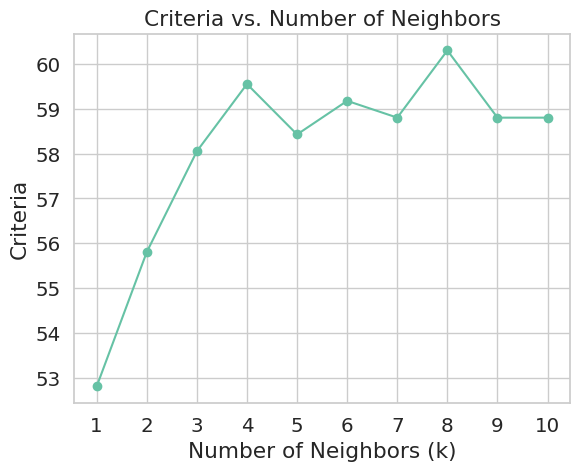

In [188]:
accuracies = []

k_values = range(1, 11)

for i in range(1, 11):
    knn_classifier = KNNClassifier(k=i, train_features=train_features[['Age', 'Fare']], train_target=train_target)
    pred = knn_classifier.predict(test_features[['Age', 'Fare']])
    accuracy_knn = criteria(test_target, pred)
    print("Accuracy of kNN:", accuracy_knn)
    accuracies.append(accuracy_knn)

plt.plot(k_values, accuracies, marker='o')
plt.title('Criteria vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Criteria')
plt.xticks(k_values)
plt.grid(True)
plt.show()    


#### 6. Выводы

По результатам видно, что метод ближайших соседей работает лучше результирующих деревьев. Можно заметить, что с ростом количества соседей, точность уменьшается, но зато для любого k > K. где K-какое-то количество соседей, точность примерно одинаковая. То есть начиная с какого то k, наш метод будет выдавать примерно одну и ту же точность. По статистике, если вы мужчина, то вы умрете на титанике.